In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from random import choice
import gzip
import scipy
import sys

class ShowProcess():
    i = 0
    max_steps = 0
    max_arrow = 50 # length of bar
    infoDone = 'done'
    
    def __init__(self, max_steps, infoDone = 'Done'):
        self.max_steps = max_steps
        self.i = 0
        self.infoDone = infoDone
    
    def show_process(self, i=None):
        if i is not None:
            self.i = i
        else:
            self.i += 1
        num_arrow = int(self.i * self.max_arrow / self.max_steps)
        num_line = self.max_arrow - num_arrow
        percent = self.i * 100.0 / self.max_steps
        process_bar = '[' + '>' * num_arrow + '-' * num_line + ']'\
            + '%.2f' % percent + '%' + '\r'
        sys.stdout.write(process_bar)
        sys.stdout.flush()
        if self.i >= self.max_steps:
            self.close()

    def close(self):
        print('')
        print(self.infoDone)
        self.i = 0

In [118]:
data_train = pd.read_csv('beer_train.csv')
data_val = pd.read_csv('beer_val.csv')
data_test = pd.read_csv('beer_test.csv')
data_train = np.array(data_train[['user_id','beer_id','review_overall']]).astype(str)
data_val = np.array(data_val[['user_id','beer_id','review_overall']]).astype(str)
data_test = np.array(data_test[['user_id','beer_id','review_overall']]).astype(str)

In [121]:
data_train = data_train[:200000]

In [122]:
users = list(set(data_train[:,0]))
items = list(set(data_train[:,1]))
nUsers = len(users)
nItems = len(items)

getBeerByUser = defaultdict(str)
getUserByBeer = defaultdict(str)

process_bar = ShowProcess(len(data_train), ' ')
for i in range(len(data_train)):
    process_bar.show_process()
    u, b, _ = data_train[i]
    if u not in getBeerByUser:
        getBeerByUser[u] = data_train[data_train[:,0]==u,1]
    if b not in getUserByBeer:
        getUserByBeer[b] = data_train[data_train[:,1]==b,0]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
 


In [123]:
users = list(set(data_train[:,0]))
items = list(set(data_train[:,1]))
nUsers = len(users)
nItems = len(items)
alpha = np.average(data_train[:,2].astype(float))

F = 5 # dimension of vector gammaUser and gammaItem
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
gammaUser = dict()
gammaItem = dict()

loss_train = []
loss_val = []

def RMSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return np.sqrt(sum(differences) / len(differences))

def prediction(user, item):
    if user not in userBiases:
        uB = 0
        uG = np.zeros(F)
    else:
        uB = userBiases[user]
        uG = gammaUser[user]
    if item not in itemBiases:
        iB = 0
        iG = np.zeros(F)
    else:
        iB = itemBiases[item]
        iG = gammaItem[item]
    result = alpha + uB + iB
    result += np.matmul(uG, iG)
    return result

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global gammaUser
    global gammaItem
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[nUsers+1:nUsers+nItems+1]))
    for i in range(nUsers):
        gammaUser[users[i]] = np.array(theta[nUsers+nItems+1+F*i:nUsers+nItems+1+F*(i+1)])
    for i in range(nItems):
        gammaItem[items[i]] = np.array(theta[nUsers+nItems+1+F*(nUsers+i):nUsers+nItems+1+F*(nUsers+i+1)])
    
def cost(theta, labels, lamb):
    global loss_train
    global loss_val
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in data_train]
    cost = RMSE(predictions, labels)
    
    pred_val = [prediction(u,b) for u,b,_ in data_val]
    cost_val = RMSE(pred_val, data_val[:,2].astype(float))
    print("train RMSE = {:1.3f}".format(cost) + "     val RMSE = {:1.3f}".format(cost_val))
    loss_train.append(cost)
    loss_val.append(cost_val)
    
    for u in userBiases:
        cost += lamb*userBiases[u]**2
        cost += lamb*sum(gammaUser[u]**2)
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
        cost += lamb*sum(gammaItem[i]**2)
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(data_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dgammaUser = dict()
    dgammaItem = dict()
    for d in data_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - d[2].astype(float)
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        dgammaUser[u] = 2/N*gammaItem[i]*diff
        dgammaItem[i] = 2/N*gammaUser[u]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        dgammaUser[u] += 2*lamb*gammaUser[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        dgammaItem[i] += 2*lamb*gammaItem[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users: dtheta += list(dgammaUser[u])
    for i in items: dtheta += list(dgammaItem[i])
    return np.array(dtheta)

In [124]:
init = [alpha] + [np.random.rand() for i in range((nUsers+nItems)*(F+1))]
x, f, d = scipy.optimize.fmin_l_bfgs_b(cost, init, derivative, args = (data_train[:,2].astype(float), 5e-5))

train RMSE = 2.450     val RMSE = 2.344
train RMSE = 1.581     val RMSE = 1.526
train RMSE = 0.967     val RMSE = 1.088
train RMSE = 0.967     val RMSE = 1.087
train RMSE = 0.966     val RMSE = 1.087
train RMSE = 0.961     val RMSE = 1.084
train RMSE = 0.945     val RMSE = 1.073
train RMSE = 0.894     val RMSE = 1.045
train RMSE = 0.908     val RMSE = 1.054
train RMSE = 0.862     val RMSE = 1.006
train RMSE = 0.986     val RMSE = 1.069
train RMSE = 0.970     val RMSE = 1.047
train RMSE = 0.888     val RMSE = 0.942
train RMSE = 0.858     val RMSE = 0.903
train RMSE = 0.888     val RMSE = 0.924
train RMSE = 0.961     val RMSE = 0.995
train RMSE = 1.061     val RMSE = 1.093
train RMSE = 1.103     val RMSE = 1.134
train RMSE = 1.149     val RMSE = 1.178
train RMSE = 1.149     val RMSE = 1.176
train RMSE = 1.087     val RMSE = 1.115
train RMSE = 1.746     val RMSE = 1.750
train RMSE = 1.172     val RMSE = 1.190
train RMSE = 1.097     val RMSE = 1.121
train RMSE = 0.996     val RMSE = 1.023


train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632
train RMSE = 0.592     val RMSE = 0.632


KeyboardInterrupt: 

In [125]:
pred_test = [prediction(u,b) for u,b,_ in data_test]
cost_test = RMSE(pred_test, data_test[:,2].astype(float))
print("test RMSE = {:1.3f}".format(cost_test))

test RMSE = 0.628


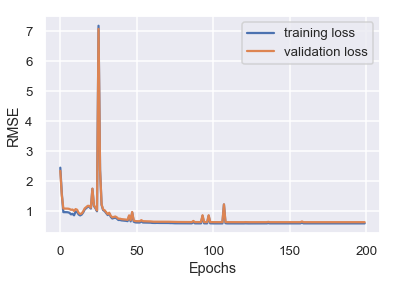

In [126]:
sns.set(style="darkgrid", context="talk", font_scale=0.8)
plt.plot(loss_train[:200])
plt.plot(loss_val[:200])
plt.legend(['training loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

In [132]:
63*500

31500